# Modelling a normal distribution (with random effects)

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('dark')

# Statistical modelling
import pymc3 as pm

import theano 
import theano.tensor as tt

import patsy
import scipy.stats as st

In [2]:
# filter some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Set seed of the random number generator for reproducibility
SEED = 880123

## The story

![dart](..\images\dart.jpg)

> Let's image that you have collected some data during a dart tournament. You measured---for sake of example--the lateral offset from the target for each participant (in centimeters). If one participant threw the dart on the left of the target, the measure was negative. Naturally, some people are more skilled than others. You want to investigate what is the general trend in lateral precision at hitting the target, as well as individual differences.

## Generate artificial data

In [4]:
n_participants = 15
n_samples_per_participant = 100

between_participant_sd = np.array([0.5])

In [5]:
participants = ['participant_{:02}'.format(i+1) for i in range(n_participants)]

In [6]:
mu_fixed_effect = np.array([0])
sd_fixed_effect = np.array([2])

In [7]:
np.random.seed(SEED)

# I draw the mu for each participant
mu_participant = np.random.normal(loc=mu_fixed_effect, scale=between_participant_sd, size=n_participants)
mu_participant.mean(), mu_participant.std()

(-0.030412130686410202, 0.5913675670542538)

In [8]:
np.random.seed(SEED)

# I draw the sd for each participant
sd_participant = np.random.normal(loc=sd_fixed_effect, scale=between_participant_sd, size=n_participants)
sd_participant = np.abs(sd_participant)
sd_participant.mean(), sd_participant.std()

(1.9695878693135898, 0.5913675670542538)

In [9]:
np.random.seed(SEED)

#draw observations for each participant based on their mu and sd
obs = np.random.normal(loc=mu_participant, scale=sd_participant, size=(n_samples_per_participant, n_participants))
obs.shape

(100, 15)

In [10]:
data = pd.DataFrame(
        {
            'dart_x_position':obs.flatten(order='C'),
            'participant':np.tile(participants, reps=n_samples_per_participant)
        }
)

In [11]:
data['participant'] = data['participant'].astype('category')

In [12]:
data.head()

,dart_x_position,participant
0,2.743469,participant_01
1,-3.112800,participant_02
2,1.652812,participant_03
3,1.438477,participant_04
4,5.551910,participant_05


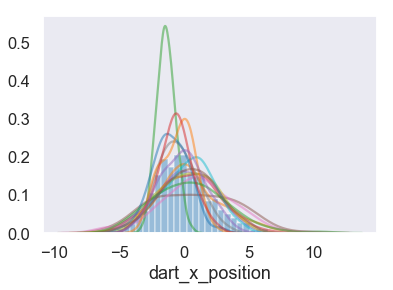

In [13]:
sns.distplot(data['dart_x_position'], norm_hist=True, kde=False)

for participant in participants:
    sns.distplot(data.loc[data['participant']==participant, 'dart_x_position'], norm_hist=True, hist=False, kde_kws={'alpha':0.5})

In [14]:
data['dart_x_position'].agg(['mean', 'std'])

mean    0.027074
std     2.183290
Name: dart_x_position, dtype: float64

## Bayesian modelling

In [15]:
# fixed effect. 
_, X = patsy.dmatrices('dart_x_position ~ 1', data=data) 
_, Z = patsy.dmatrices('dart_x_position ~ 0 + participant', data=data)
X.shape, Z.shape

((1500, 1), (1500, 15))

In [16]:
# Sampler settings
BURNIN=1000
TUNE=1000
SAMPLES=1000

### Build the model

In [17]:
with pm.Model() as model:
    
    ## Fixed effect
    # Prior on 'mu'
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10, shape=X.shape[1])
    
    ## Random effect
    # mu
    gamma_mu_sd = pm.HalfNormal('gamma_mu_sd', sd=5)
    gamma_mu_raw = pm.Normal('gamma_mu_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_mu = pm.Deterministic('gamma_mu', gamma_mu_raw * gamma_mu_sd)

    mu = tt.dot(np.asarray(X), beta_mu) + \
         tt.dot(np.asarray(Z), gamma_mu)
    
    # Prior on 'sd'
    beta_sd = pm.Normal('beta_sd', mu=0, sd=5, shape=X.shape[1])

    gamma_sd_sd = pm.HalfNormal('gamma_sd_sd', sd=1)
    gamma_sd_raw = pm.Normal('gamma_sd_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_sd = pm.Deterministic('gamma_sd', gamma_sd_raw * gamma_sd_sd)
    
    sd = tt.sqrt(tt.exp(tt.dot(np.asarray(X), beta_sd))) + \
         tt.sqrt(tt.exp(tt.dot(np.asarray(Z), gamma_sd)))
    
    ## Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sd=sd, observed=data['dart_x_position'].values)

In [18]:
model.check_test_point()

beta_mu                -3.22
gamma_mu_sd_log__      -0.77
gamma_mu_raw          -13.78
beta_sd                -2.53
gamma_sd_sd_log__      -0.77
gamma_sd_raw          -13.78
likelihood          -3311.44
Name: Log-probability of test_point, dtype: float64

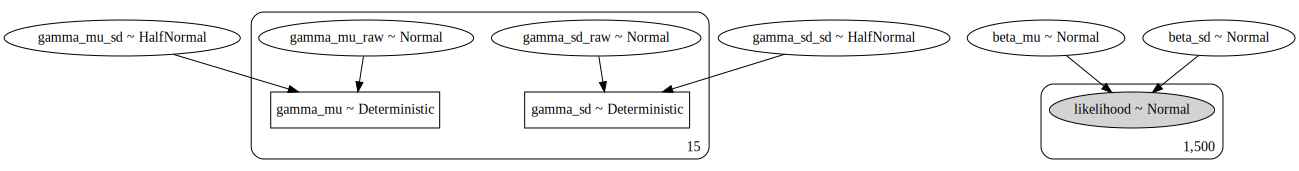

In [19]:
pm.model_to_graphviz(model)

### Sample from the model

In [20]:
with model:
    trace = pm.sample(draws=SAMPLES+BURNIN, tune=TUNE, chains=4, cores=4, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

# discard burnin samples
trace = trace[BURNIN:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma_sd_raw, gamma_sd_sd, beta_sd, gamma_mu_raw, gamma_mu_sd, beta_mu]
Sampling 4 chains: 100%|████████████████████████████████████████| 12000/12000 [02:48<00:00, 71.37draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


### Diagnose the sampling

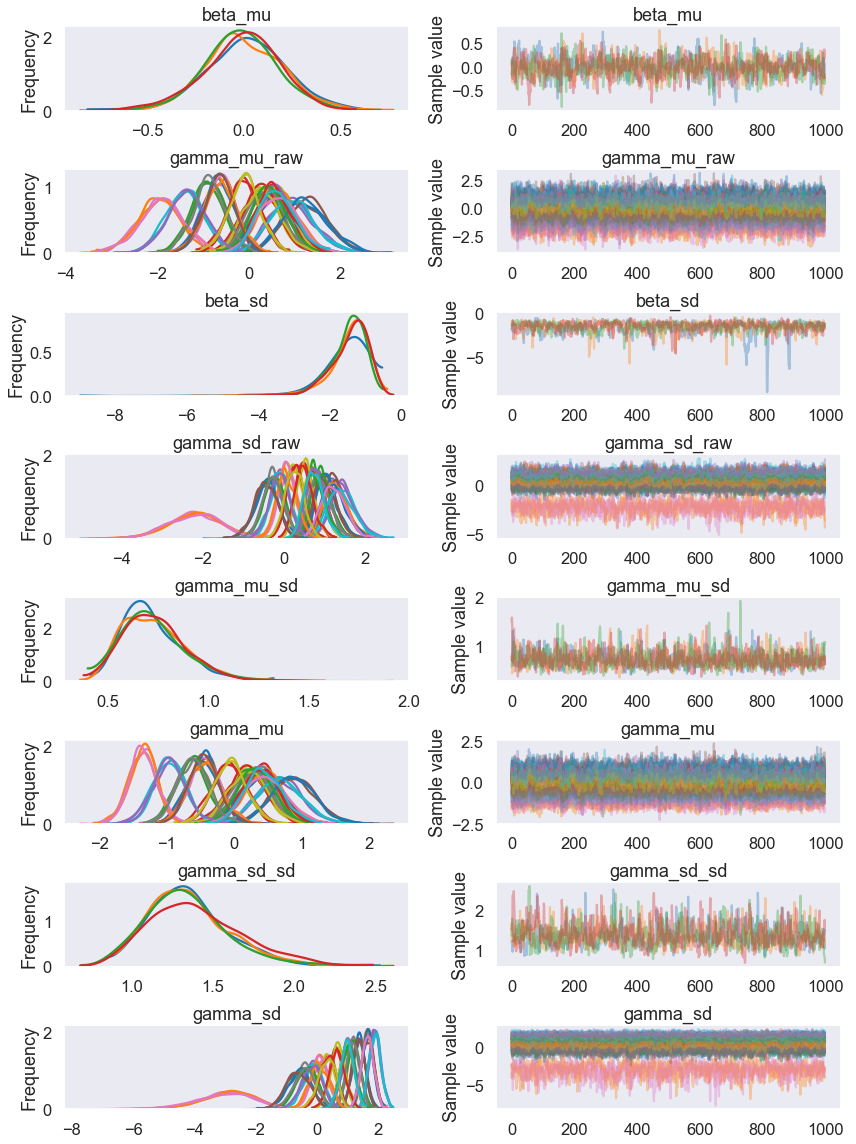

In [21]:
pm.traceplot(trace);

### Summarize the posterior density
The summary indicates that we succeeded at recovering the underlying parameters of the distribution.

In [22]:
pm.summary(trace, varnames=['beta_mu', 'gamma_mu_sd']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_mu__0,-0.00,0.20,0.01,-0.39,0.40,738.13,1.0
gamma_mu_sd,0.73,0.16,0.00,0.46,1.06,960.55,1.0


In [23]:
pm.summary(trace, varnames=['beta_sd', 'gamma_sd_sd'], transform=lambda x: np.sqrt(np.exp(x))).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_sd__0,0.49,0.12,0.00,0.26,0.71,628.01,1.0
gamma_sd_sd,2.00,0.28,0.01,1.54,2.56,674.35,1.0


### Posterior predictive check

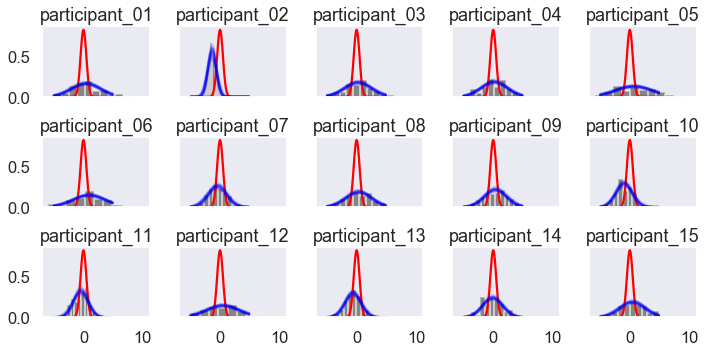

In [24]:
fig, ax = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(10, 5))
ax = ax.ravel()

THIN = 100
X = np.arange(-5, 5, 0.1)

for i, subject in enumerate(participants): 
    ax[i].plot(X, st.norm.pdf(x=X, loc=trace['beta_mu'].mean(), scale=np.sqrt(np.exp(trace['beta_sd'])).mean()), color='red')
    
    for mu, mu_offset, sd, sd_offset in zip(
                                    trace['beta_mu'][::THIN, :],
                                    trace['gamma_mu'][::THIN, i], 
                                    trace['beta_sd'][::THIN, :],
                                    trace['gamma_sd'][::THIN, i]
                                    ):
        
        ax[i].hist(data.dart_x_position[data.participant==subject], density=True, facecolor='gray', alpha=0.05)
        ax[i].plot(X, st.norm.pdf(x=X, loc=mu+mu_offset, scale=np.sqrt(np.exp(sd))+np.sqrt(np.exp(sd_offset))), color='blue', alpha=0.05)
        ax[i].set_title(subject)
    
plt.tight_layout()

The posterior predictive check suggests that our model generates credible observations, because the fit agrees well with the experimental data for each subject.

## Statistical inference

_to be continued_